### This notebook generates the CAPE-omega relationships for MCSs in the idealized RCE simulations. First import libraries and constants.

In [1]:
import numpy as np
from scipy import stats
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from matplotlib import cm
import random

from scipy.optimize import curve_fit

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

# blue-to-red colormap
BR_color_cycle = ["navy", "blue", "lightskyblue", "tomato", "red", "darkred"]

In [2]:
# parameter values for this script
ssts = np.arange( 290, 315, 5 )
pc2 = 99
nbin = 25
font_size = 20
sz = 80
threshold = 15

### Loading RCE data and identifying the 550 hPa level

In [8]:
path = '/groups/sylvia/JAS-MCS-rain/RCE-postprocessed/execution2/'
mean_RCE, p99_RCE, rad = read_RCE_files( path )

# Verifying that 17 is the index closest to 550 hPa
for i in np.arange(10):
    n = random.randint( 0, mean_RCE[0]['omega'].shape[1] )
    print( mean_RCE[0]['p'][n,17].values )

539.47406
539.23
538.958
538.8001
538.96796
538.8549
539.67285
539.189
538.86707
539.342


In [19]:
cape_bins_list = [ [] for i in mean_RCE ]
ascent_list = [ [] for i in mean_RCE ]
ascent_99_list = [ [] for i in mean_RCE ]
ascent_error_list = [ [] for i in mean_RCE ]
for iterator, array in enumerate( mean_RCE ):
    cape_RCE = array['CAPE'].to_numpy()
    ascent_RCE = array['omega'][:,17].to_numpy()  # pressure velocities at 550 hPa, multiply by -1 as negative = ascent
    ascent_RCE = xr.where( ascent_RCE < 0, -1.*ascent_RCE, np.nan ) # we only want ascent rates

    cape_bins, ascent_vals, _, ascent_99_vals, _, ascent_error, _, _ = \
        bin_stat_function( nbin, np.nanmin(cape_RCE), np.nanpercentile(cape_RCE,95), cape_RCE, ascent_RCE, pc2=pc2, threshold=threshold ) #20000 as upper bound for max_RCE
    
    cape_bins_list[iterator] = cape_bins
    ascent_list[iterator] = ascent_vals
    ascent_99_list[iterator] = ascent_99_vals
    ascent_error_list[iterator] = ascent_error

20
22
25
28
32


### Filter the scaling of CAPE and omega for different MCS extents

In [22]:
cape_RCE = RCE_concat( mean_RCE, 'CAPE' )
omega_RCE = RCE_concat( mean_RCE, 'omega' )
omega_RCE = xr.where( omega_RCE[:,17] < 0, -1.*omega_RCE[:,17], np.nan ) # we only want ascent rates
y = omega_RCE
rad_RCE = np.concatenate( [r for r in rad], axis=0 )
unit = np.sqrt( np.nanpercentile(cape_RCE,99) )/4.

loo = np.percentile( rad_RCE, 25 )
upp = np.percentile( rad_RCE, 75 )
cape_bins_all, ascent_vals_all, _, ascent99_vals_all, _, _, _, _ = \
        bin_stat_function( nbin, np.nanmin(cape_RCE), np.nanpercentile(cape_RCE,95), cape_RCE, omega_RCE, pc2=pc2, threshold=threshold )
cape_bins_small, ascent_vals_small, _, ascent99_vals_small, _, _, _, _ = \
        bin_stat_function( nbin, np.nanmin(cape_RCE), np.nanpercentile(cape_RCE,95), cape_RCE[rad_RCE<=loo],
                          omega_RCE[rad_RCE<=loo], pc2=pc2, threshold=threshold )
cape_bins_large, ascent_vals_large, _, ascent99_vals_large, _, _, _, _ = \
        bin_stat_function( nbin, np.nanmin(cape_RCE), np.nanpercentile(cape_RCE,95), cape_RCE[rad_RCE>=upp],
                          omega_RCE[rad_RCE>=upp], pc2=pc2, threshold=threshold )

### Plot the ascent rate versus CAPE

In [23]:
def squared(x):
    return x**2

def sqrt(x):
    return np.sqrt(x)

0.16681088576978956
0.13159298623923837
0.11458919509882956
0.08540253457145655
0.06872777060536236


<Figure size 432x288 with 0 Axes>

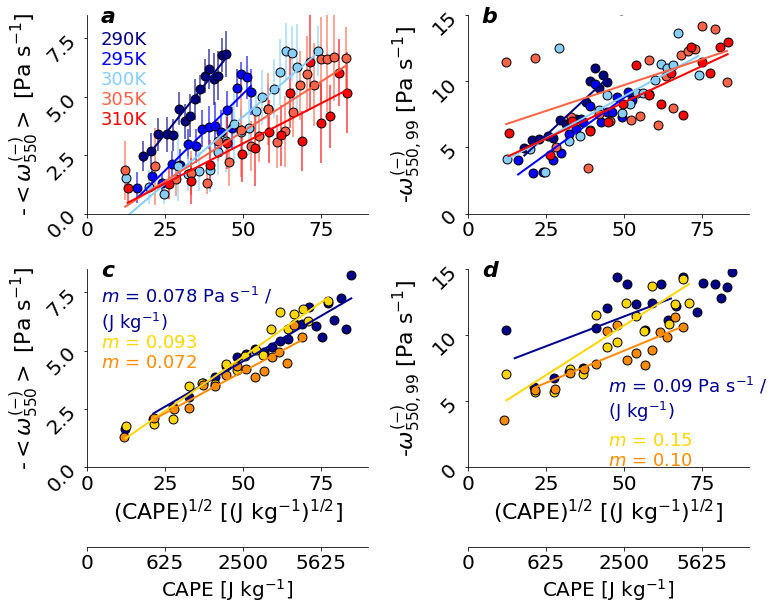

In [36]:
plt.clf()
fig, ax = plt.subplots( 2, 2, figsize =(11, 9) )

ylab = [ r'-$<\omega_{550}^{(-)}>$ [Pa s$^{-1}$]', r'-$\omega_{550,99}^{(-)}$ [Pa s$^{-1}$]',
         r'-$<\omega_{550}^{(-)}>$ [Pa s$^{-1}$]', r'-$\omega_{550,99}^{(-)}$ [Pa s$^{-1}$]' ]
labels = [ '', '' , r'(CAPE)$^{1/2}$ [(J kg$^{-1})^{1/2}$]', '(CAPE)$^{1/2}$ [(J kg$^{-1})^{1/2}$]' ]
let = [ 'a', 'b', 'c', 'd' ]
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size+2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})
cape_array = np.linspace( 15, 65, 50 )

for i, axis in enumerate(ax.flatten()): 
    axis.set( ylabel = ylab[i] )
    axis.set_xlim( [0, 90] )
    axis.spines['top'].set_visible( False )
    axis.spines['right'].set_visible( False )
    axis.set( xlabel = labels[i] )
    for t in axis.get_yticklabels():
        t.set_rotation(45)
    
    axis.text( 0.05, 0.96, let[i], weight='bold', style='italic', fontsize=font_size+2, transform=axis.transAxes )
    if i == 0:
        for j, k, l, m in zip(cape_bins_list, ascent_list, np.arange(len(cape_bins_list)), ascent_error_list):
            axis.scatter( np.sqrt(j), k, color = BR_color_cycle[l], s=sz, edgecolor='black', label=str(ssts[l])+' K'  )
            axis.errorbar( np.sqrt(j), k, xerr=None, yerr=m/2, color = BR_color_cycle[l], ls='none', zorder=-1, alpha=0.75 )
            axis.text( 0.05, 0.85-l*0.1, str(ssts[l]) + 'K', color=BR_color_cycle[l], fontsize=font_size-2, transform=axis.transAxes )
            out, y_predicted, x_input, _ = linindx( np.sqrt(j), k )
            print(out.slope)
            axis.plot( x_input, y_predicted, color=BR_color_cycle[l], linewidth=2, zorder=10 )
        axis.set_ylim( [0, 8.5] )
        
    elif i == 1:
        for j, k, l in zip(cape_bins_list, ascent_99_list, np.arange(len(cape_bins_list))):
            axis.scatter( np.sqrt(j), k, color = BR_color_cycle[l], s=sz, edgecolor='black', label=str(ssts[l])+' K' )
            out, y_predicted, x_input, _ = linindx( np.sqrt(j), k )
            axis.plot( x_input, y_predicted, color=BR_color_cycle[l], linewidth=2, zorder=10 )
        axis.set_ylim( [0, 15] )
        
    elif i == 2:
        axis.scatter( np.sqrt(cape_bins_all), ascent_vals_all, s=sz, color='darkblue', edgecolor='k' )
        out, y_predicted, x_input, _ = linindx( np.sqrt(cape_bins_all), ascent_vals_all )
        axis.plot( x_input, y_predicted, color='darkblue', linewidth=2, zorder=10 )
        axis.text( 0.05, 0.7, r"$m$ = " + f"{out.slope:.3f}" + r" Pa s$^{-1}$ / " + "\n" + "(J kg$^{-1}$)", color='darkblue',
                  fontsize=font_size-2, transform=axis.transAxes )
        
        axis.scatter( np.sqrt(cape_bins_small), ascent_vals_small, s=sz, color='gold', edgecolor='k' )
        out, y_predicted, x_input, _ = linindx( np.sqrt(cape_bins_small), ascent_vals_small )
        axis.plot( x_input, y_predicted, color='gold', linewidth=2, zorder=10 )
        axis.text( 0.05, 0.6, r"$m$ = " + f"{out.slope:.3f}", color='gold',
                  fontsize=font_size-2, transform=axis.transAxes )
        
        axis.scatter( np.sqrt(cape_bins_large), ascent_vals_large, s=sz, color='darkorange', edgecolor='k' )
        out, y_predicted, x_input, _ = linindx( np.sqrt(cape_bins_large), ascent_vals_large )
        axis.plot( x_input, y_predicted, color='darkorange', linewidth=2, zorder=10 )
        axis.text( 0.05, 0.5, r"$m$ = " + f"{out.slope:.3f}", color='darkorange',
                  fontsize=font_size-2, transform=axis.transAxes )
        
        ax2 = axis.secondary_xaxis( -0.4, functions=(squared, sqrt) )
        ax2.set_xticks( [0, 625, 2500, 5625] )
        ax2.set_xlabel( r'CAPE [J kg$^{-1}$]', fontsize=font_size )
        axis.set_ylim( [0, 8.5] )
        
    else:
        axis.scatter( np.sqrt(cape_bins_all), ascent99_vals_all, s=sz, color='darkblue', edgecolor='k' )
        out, y_predicted, x_input, _ = linindx( np.sqrt(cape_bins_all), ascent99_vals_all )
        axis.plot( cape_array, out.slope*cape_array + out.intercept, color='darkblue', linewidth=2, zorder=10 )
        axis.text( 0.5, 0.25, r"$m$ = " + f"{out.slope:.2f}" + r" Pa s$^{-1}$ / " + "\n" + "(J kg$^{-1}$)", color='darkblue',
                  fontsize=font_size-2, transform=axis.transAxes )
        #print(out.slope, out.rvalue, out.pvalue)
        
        axis.scatter( np.sqrt(cape_bins_small), ascent99_vals_small, s=sz, color='gold', edgecolor='k' )
        out, y_predicted, x_input, _ = linindx( np.sqrt(cape_bins_small), ascent99_vals_small )
        axis.plot( x_input, y_predicted, color='gold', linewidth=2, zorder=10 )
        axis.text( 0.5, 0.11, r"$m$ = " + f"{out.slope:.2f}", color='gold',
                  fontsize=font_size-2, transform=axis.transAxes )
        #print(out.slope, out.rvalue, out.pvalue)
        
        axis.scatter( np.sqrt(cape_bins_large), ascent99_vals_large, s=sz, color='darkorange', edgecolor='k' )
        out, y_predicted, x_input, _ = linindx( np.sqrt(cape_bins_large), ascent99_vals_large )
        axis.plot( x_input, y_predicted, color='darkorange', linewidth=2, zorder=10 )
        axis.text( 0.5, 0.01, r"$m$ = " + f"{out.slope:.2f}", color='darkorange',
                  fontsize=font_size-2, transform=axis.transAxes )
        #print(out.slope, out.rvalue, out.pvalue)
                
        ax2 = axis.secondary_xaxis( -0.4, functions=(squared, sqrt) )
        ax2.set_xticks( [0, 625, 2500, 5625] )
        ax2.set_xlabel( r'CAPE [J kg$^{-1}$]', fontsize=font_size )
        axis.set_ylim( [0, 15] )
            
plt.tight_layout()
#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/cape-ascent-RCE.pdf', bbox_inches='tight' )
plt.show()